In [205]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage.draw import disk

In [206]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Tue, 28 Mar 2023 15:18:11] [INFO    ] [topostats] Extracting image from Flat\20230118_KPN001.0_00011.spm
[Tue, 28 Mar 2023 15:18:11] [INFO    ] [topostats] Loading image from : Flat\20230118_KPN001.0_00011.spm
[Tue, 28 Mar 2023 15:18:11] [INFO    ] [topostats] [20230118_KPN001.0_00011] : Loaded image from : Flat\20230118_KPN001.0_00011.spm
[Tue, 28 Mar 2023 15:18:11] [INFO    ] [topostats] [20230118_KPN001.0_00011] : Extracted channel Height
[Tue, 28 Mar 2023 15:18:11] [INFO    ] [topostats] [20230118_KPN001.0_00011] : Pixel to nm scaling : 12.69013671875


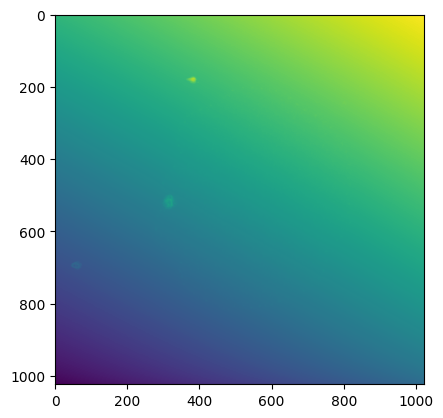

In [207]:
    #Flat
#file = Path('./Flat/20221213_KDNA001.0_00020.spm')
#file = Path('./flat/20230118_KPN001.0_00005.spm')
file = Path('./Flat/20230118_KPN001.0_00011.spm')
# file = Path('./flat/20230118_KPN001.0_00023.spm')
#file = Path('./flat/20230125_KPN005.0_00006.spm')
#file = Path('./flat/20230125_KPN005.0_00028.spm')
# file = Path('./flat/20230126_KPN005.0_00004.spm')
# file = Path('./flat/20230126_KPN005.0_00013.spm')
# file = Path('./flat/20230126_KPN005.0_00019.spm')
# file = Path('./flat/20230126_KPN005.0_00024.spm')
# file = Path('./flat/20230217_KPN010.0_00010.spm')
# file = Path('./flat/20230314_KPN015.0_00016.spm')
    #Folded
# file = Path('./flat')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [266]:
#Parameters
Rosette_Thres = 1
Gauss_Min_Size = 5
Gauss_Max_Size = 300
Gauss_Sigma = 10
Gauss_Thres = 0.005
Fibril_Min_Size = 10
Fibril_Max_Size = 300
Threshold_Dist = 0.75



In [249]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Tue, 28 Mar 2023 15:26:04] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : Median flattening without mask
[Tue, 28 Mar 2023 15:26:05] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : Plane tilt removal without mask
[Tue, 28 Mar 2023 15:26:05] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : x-polyfit 1st order: [  0.07576316 -38.78020272]
[Tue, 28 Mar 2023 15:26:05] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : y-polyfit 1st order: [ 8.78982809e-19 -5.18988646e-16]
[Tue, 28 Mar 2023 15:26:05] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : Removing x plane tilt
[Tue, 28 Mar 2023 15:26:07] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : removing y plane tilt
[Tue, 28 Mar 2023 15:26:08] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : Remove quadratic bow without mask
[Tue, 28 Mar 2023 15:26:08] [INFO    ] [topostats] [Flat\20230118_KPN001.0_00011.spm] : x polyfit 2nd order: [ 7.32468034e-07 -7.49314798e-

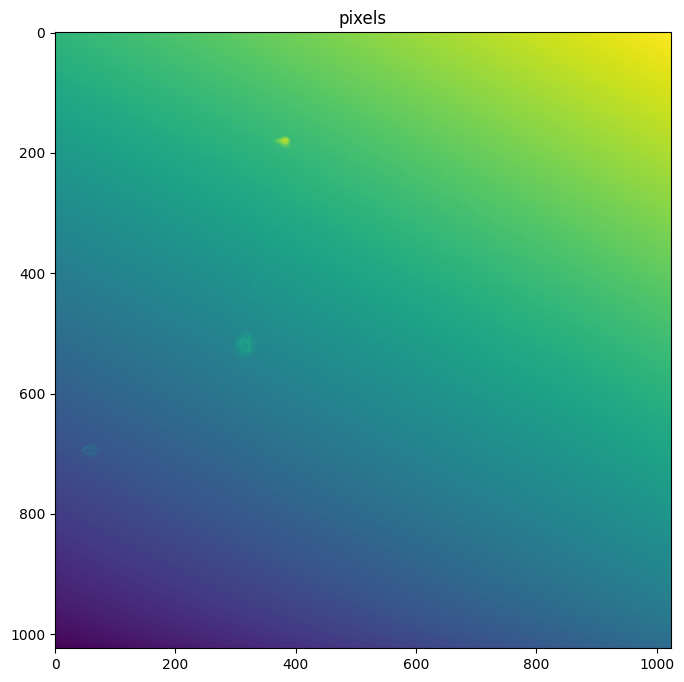

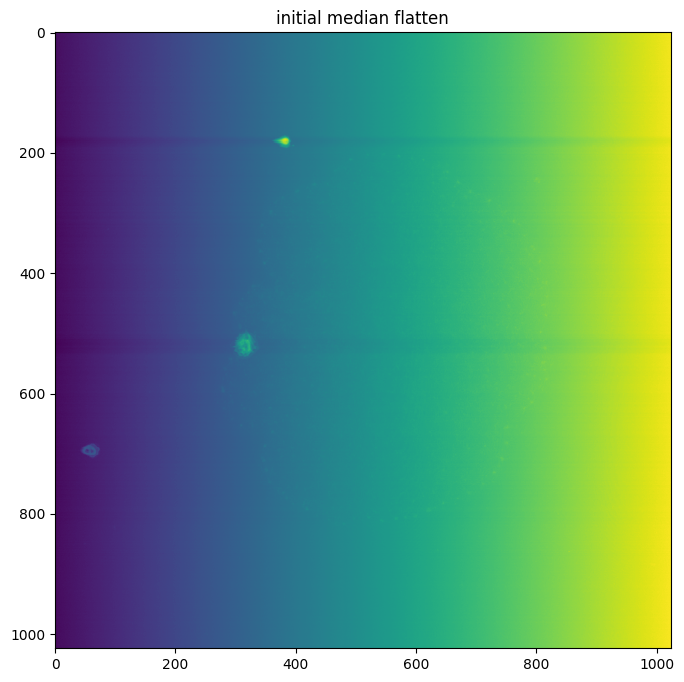

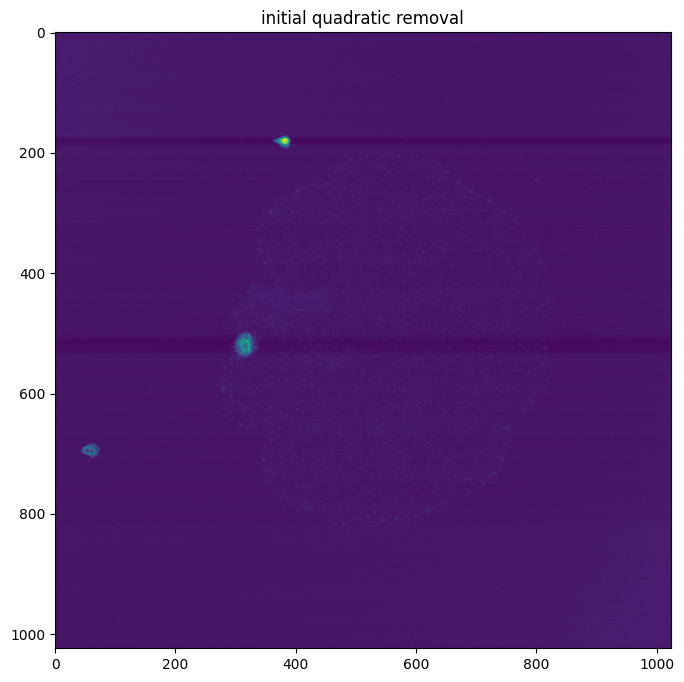

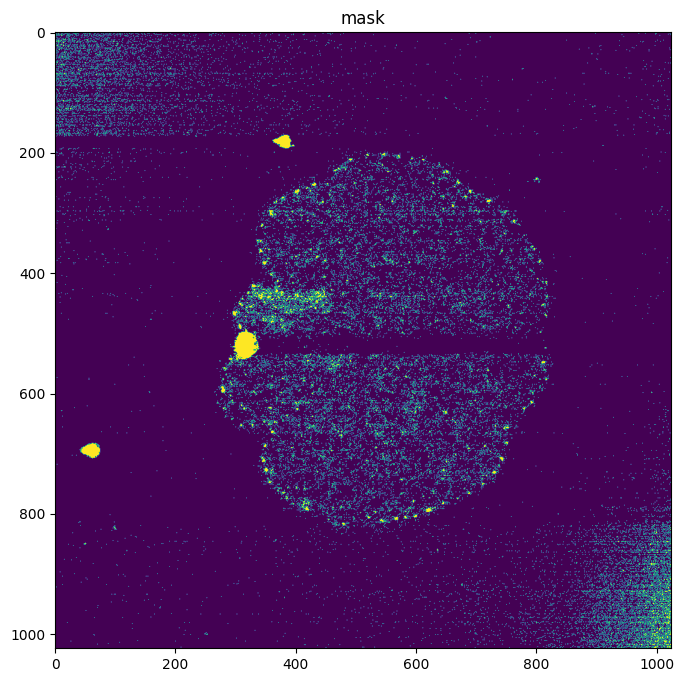

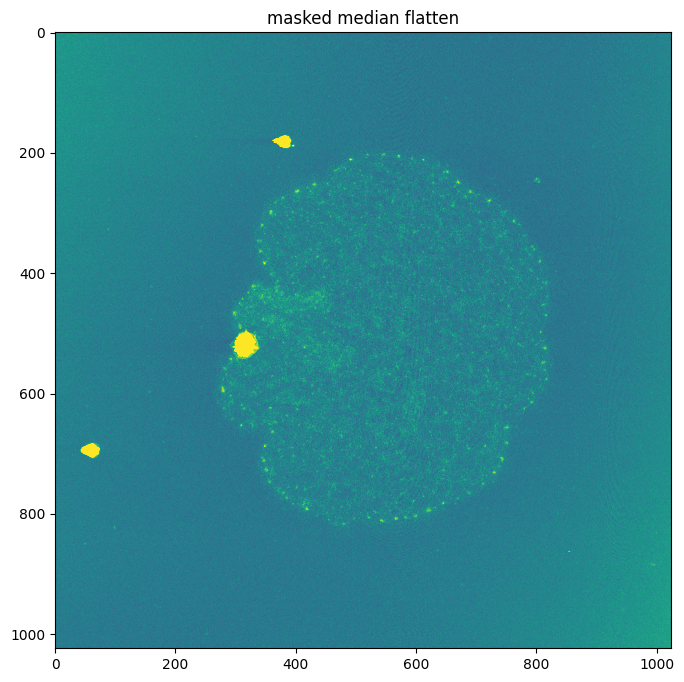

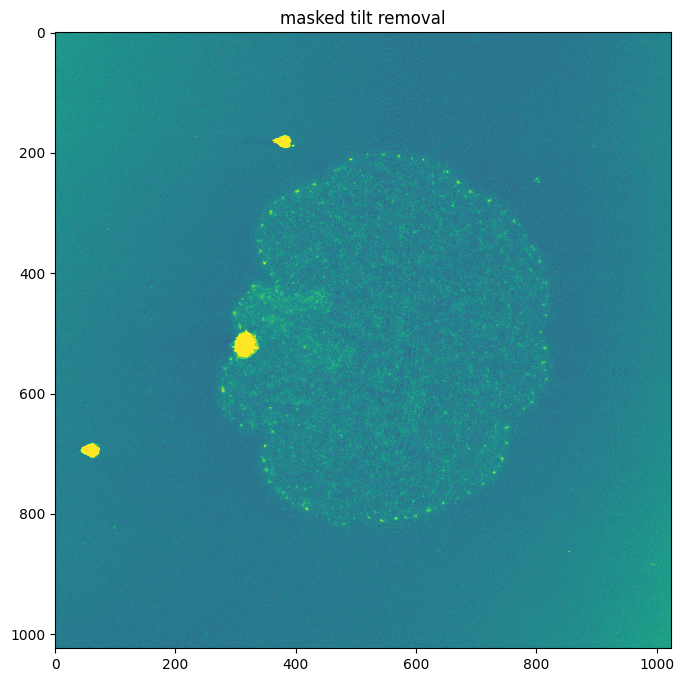

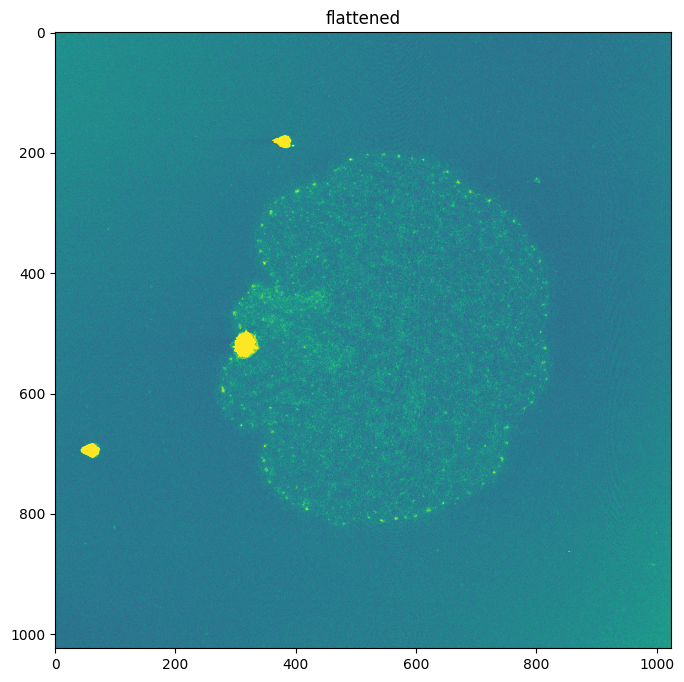

In [250]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 0.974099426547518})
[Tue, 28 Mar 2023 15:26:24] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.974099426547518


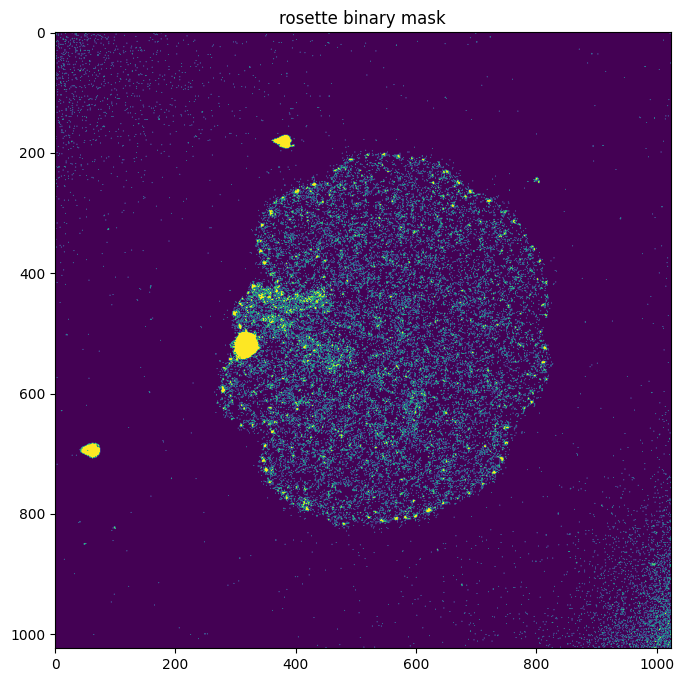

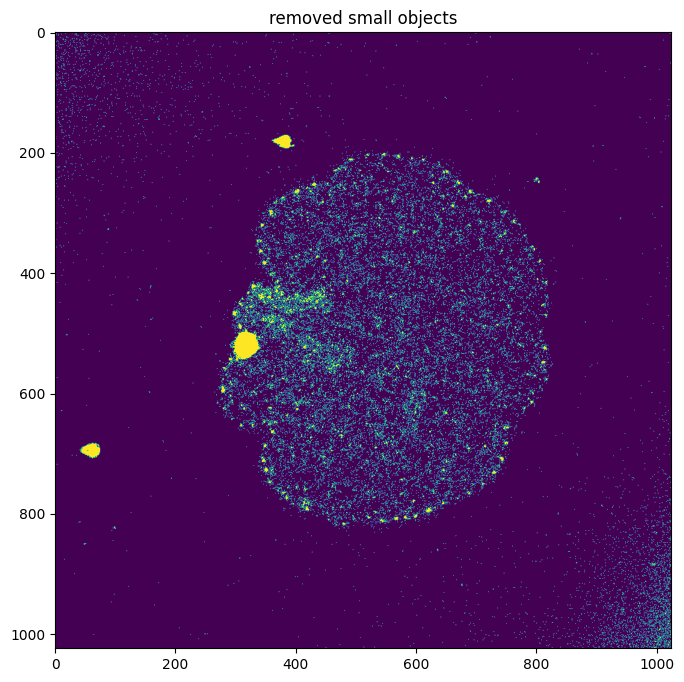

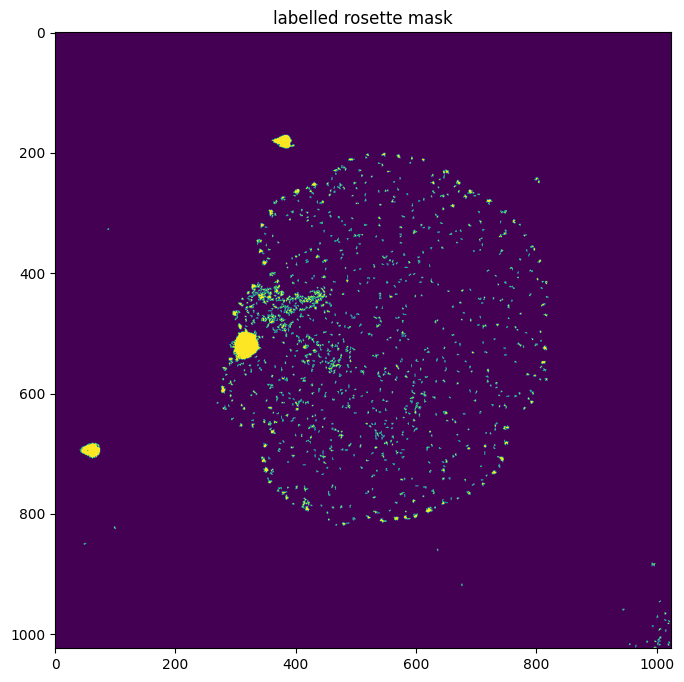

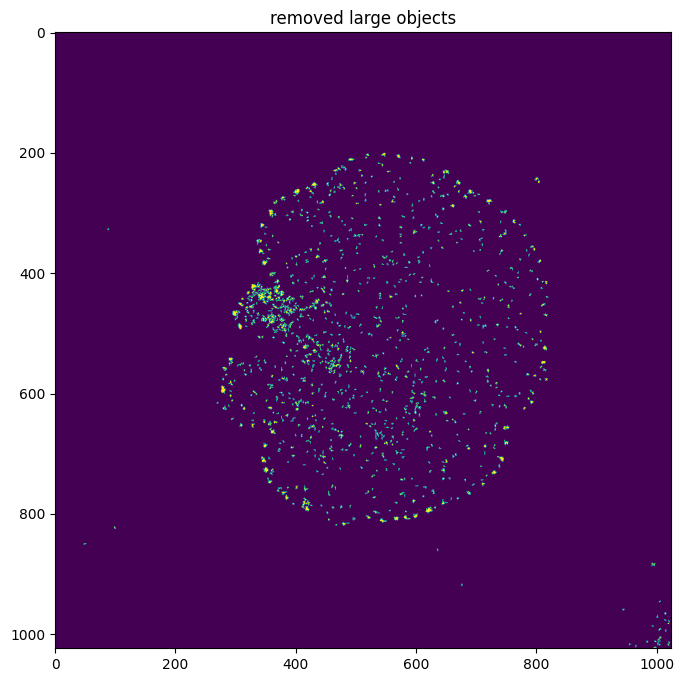

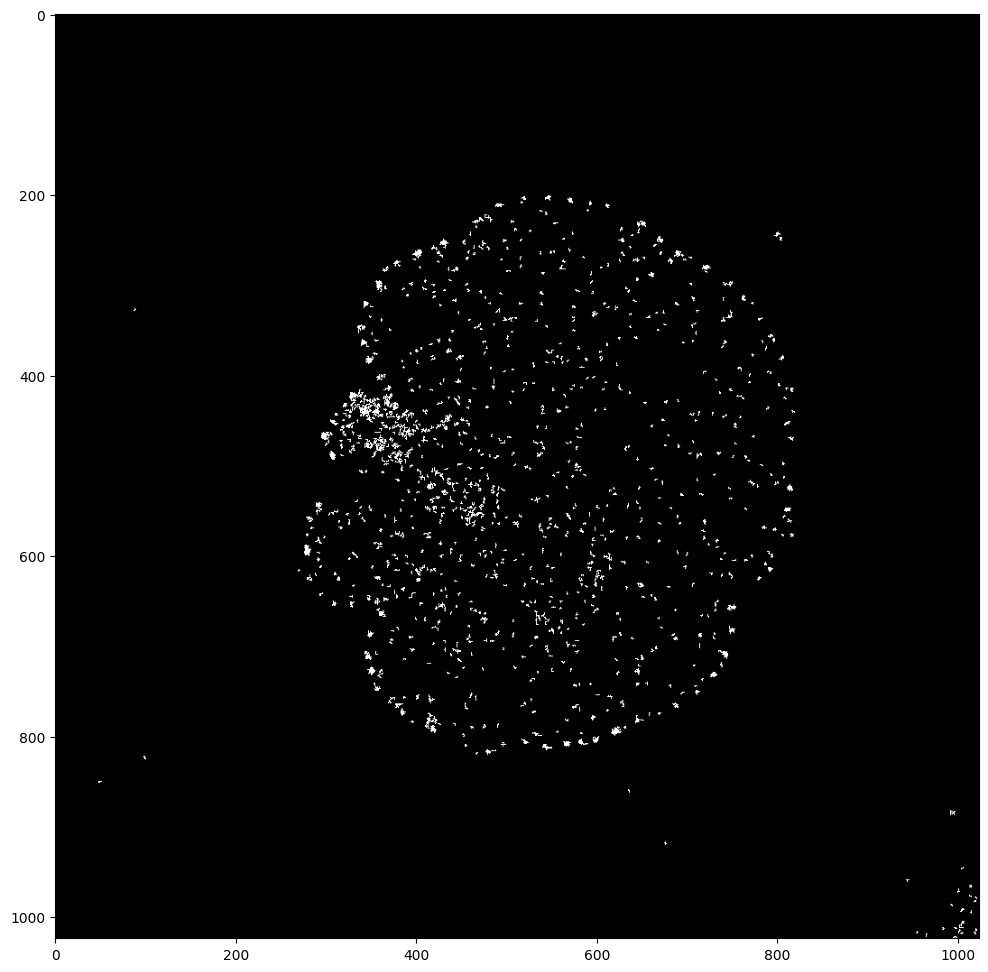

In [251]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': Rosette_Thres, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, Gauss_Min_Size)
plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Gauss_Max_Size:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


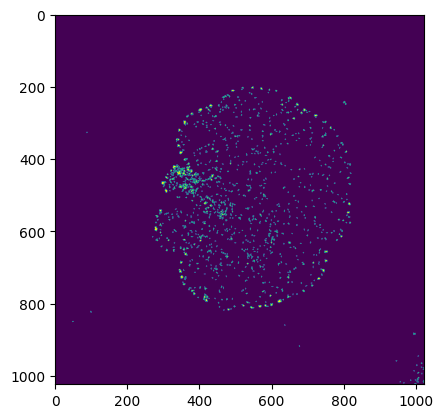

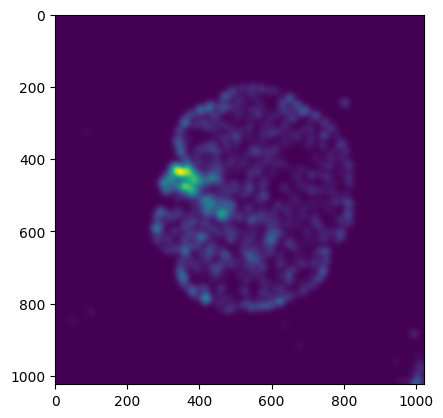

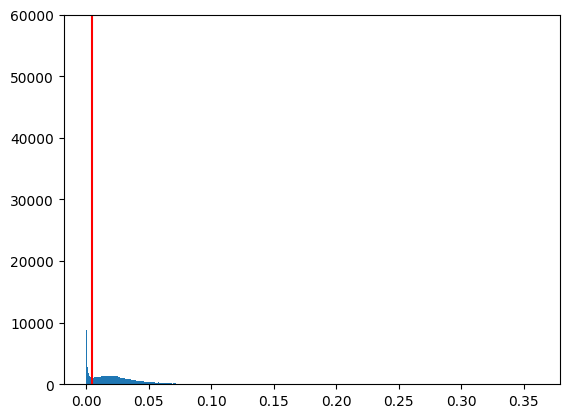

otsu threshold: 0.005


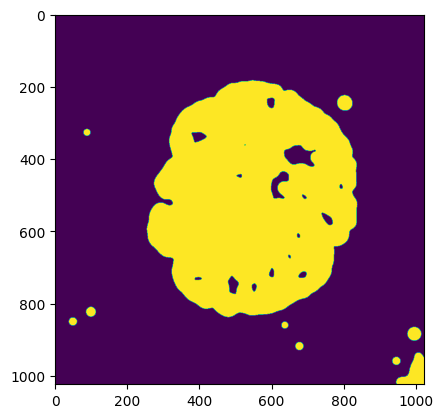

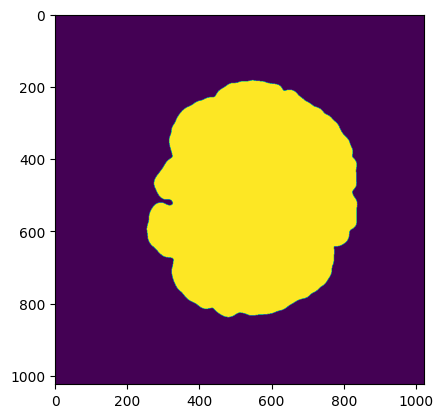

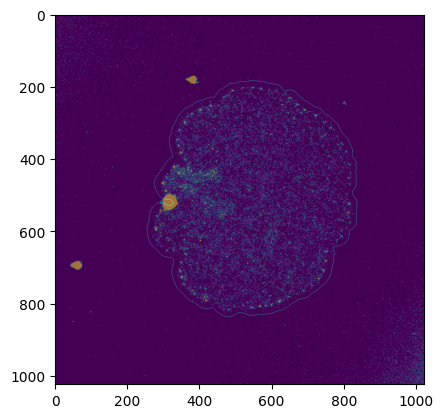

In [252]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
gauss = gaussian(labelled_rosette_mask.astype(bool), Gauss_Sigma)
plt.imshow(gauss)
plt.show()



# threshold = threshold_otsu(gauss)
threshold = Gauss_Thres

fig, ax = plt.subplots()
ax.hist(gauss.flatten(), bins='auto')
ax.set_ylim(0, 60000)
plt.axvline(x=threshold, color='r')
plt.show()

print(f'otsu threshold: {threshold}')
thresholded = gauss > threshold
plt.imshow(thresholded)
plt.show()

labelled = label(thresholded)
region_props = regionprops(labelled)
max_size = max([props.area for props in region_props])
thresholded = remove_small_objects(thresholded, min_size=max_size-1)
thresholded = ndimage.binary_fill_holes(thresholded)
plt.imshow(thresholded)
plt.show()

# Add padding (needed for erosion)
padded = np.pad(thresholded, 1)
# Erode by 1 pixel
eroded = binary_erosion(padded)
# Remove padding
eroded = eroded[1:-1, 1:-1]

# Edges is equal to the difference between the
# original image and the eroded image.
edges = thresholded.astype(int) - eroded.astype(int)
plt.imshow(rosette_mask)
plt.imshow(edges, alpha=0.5)
plt.show()

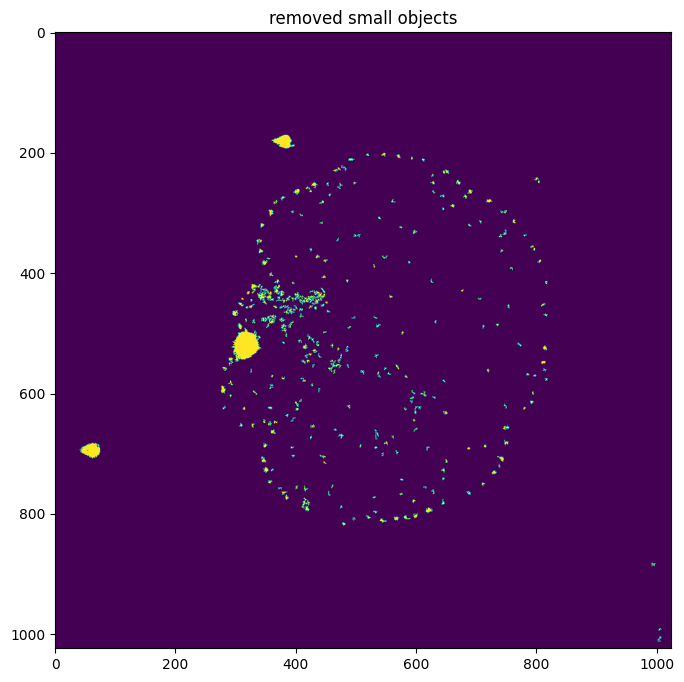

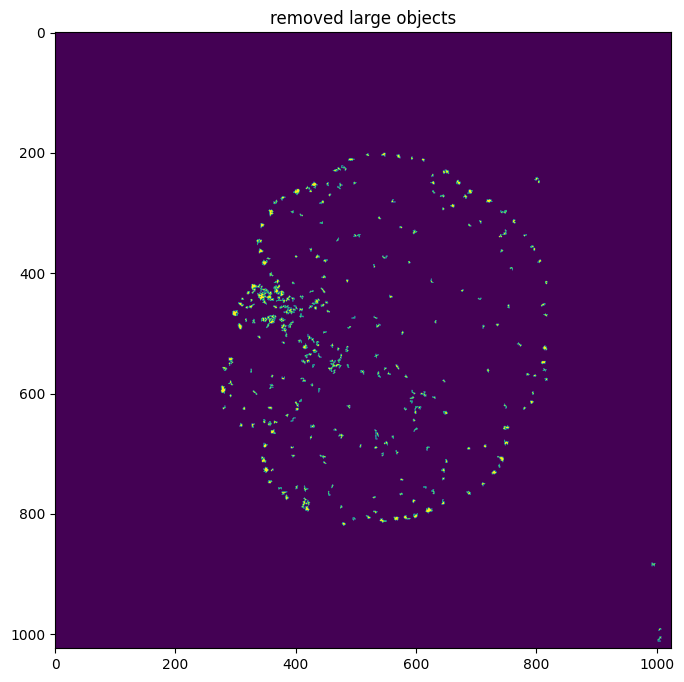

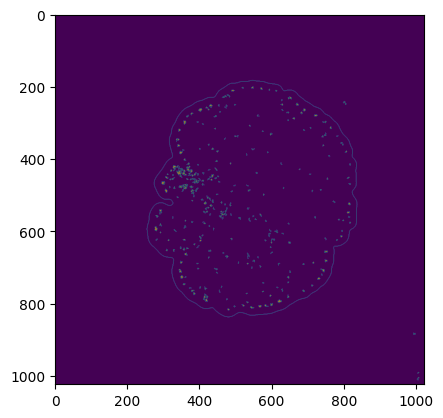

In [253]:
#Second Thresholding
fibril_thres = rosette_mask.copy()
# Remove small objects
fib_removed_small_objects = remove_small_objects(fibril_thres, Fibril_Min_Size)
plot(fib_removed_small_objects.astype(bool), title='removed small objects', zlimit=False)
#Remove large objects
fibril_rosette_mask = label(fib_removed_small_objects)
#plot(fibril_rosette_mask.astype(bool), title='fibril rosette mask', zlimit=False)
regions = regionprops(fibril_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Fibril_Max_Size:
        fibril_rosette_mask[fibril_rosette_mask==props.label] = 0

plot(fibril_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()


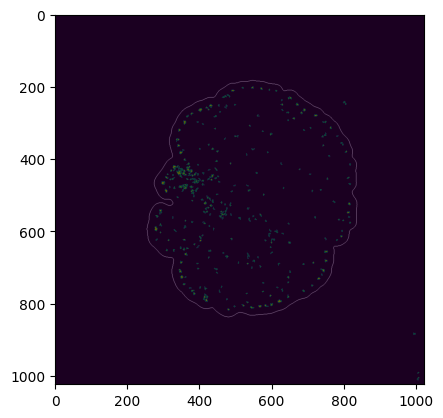

mean distance: 80.57628759388137
std dev distance: 62.66540165549259


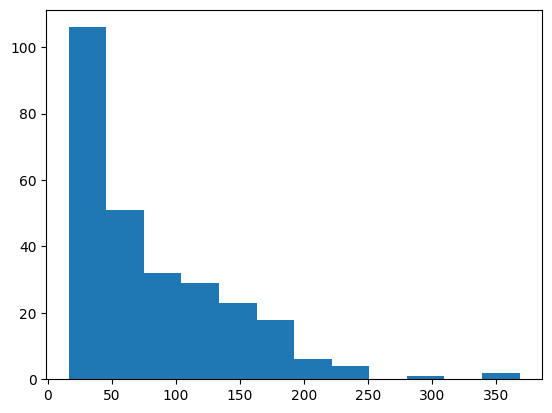

distance threshold: 33.577236352261934
points shape: (84, 2)


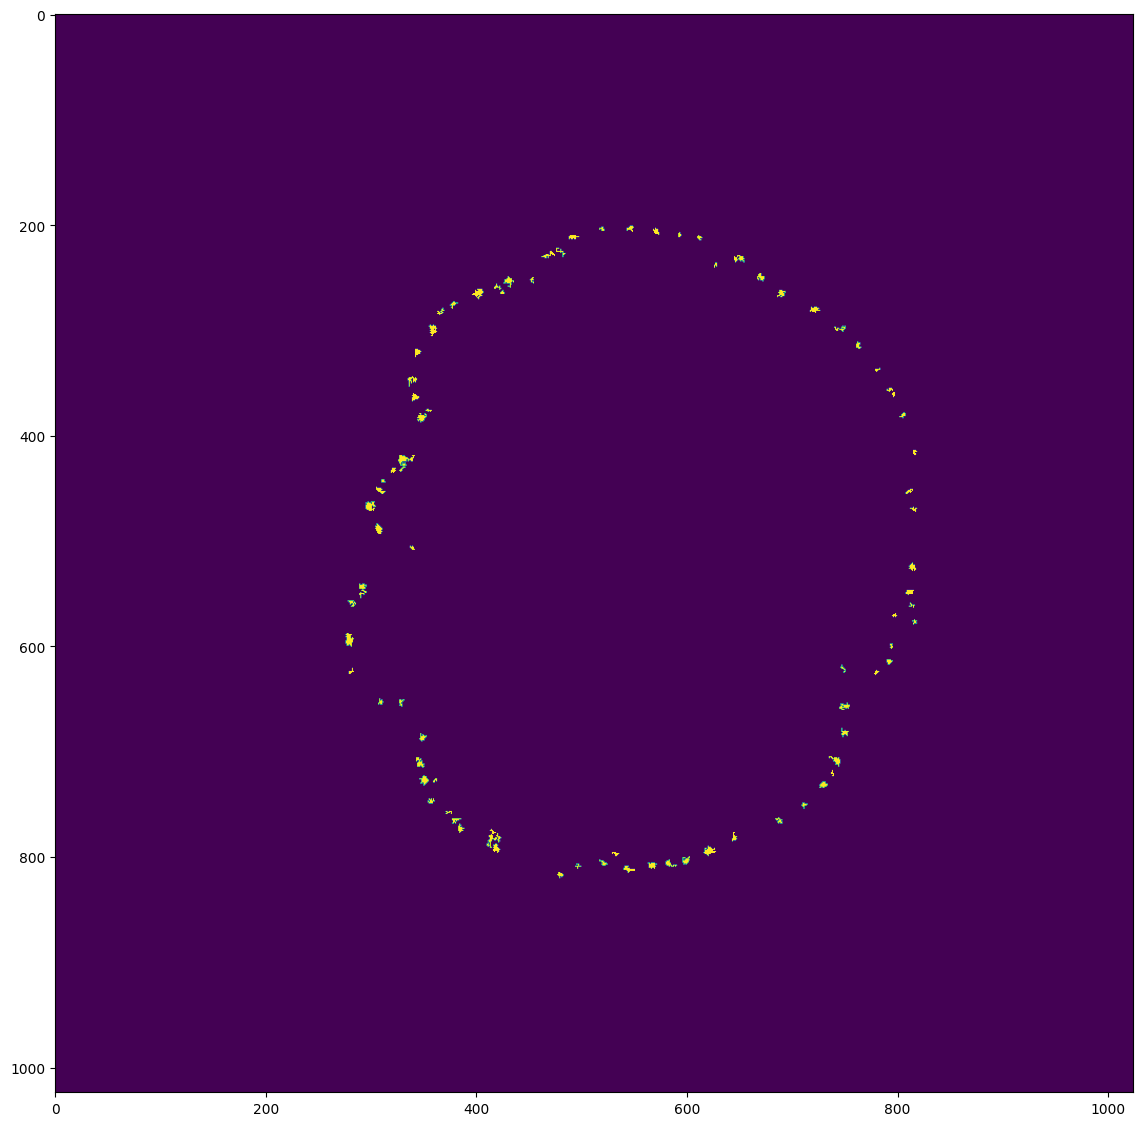

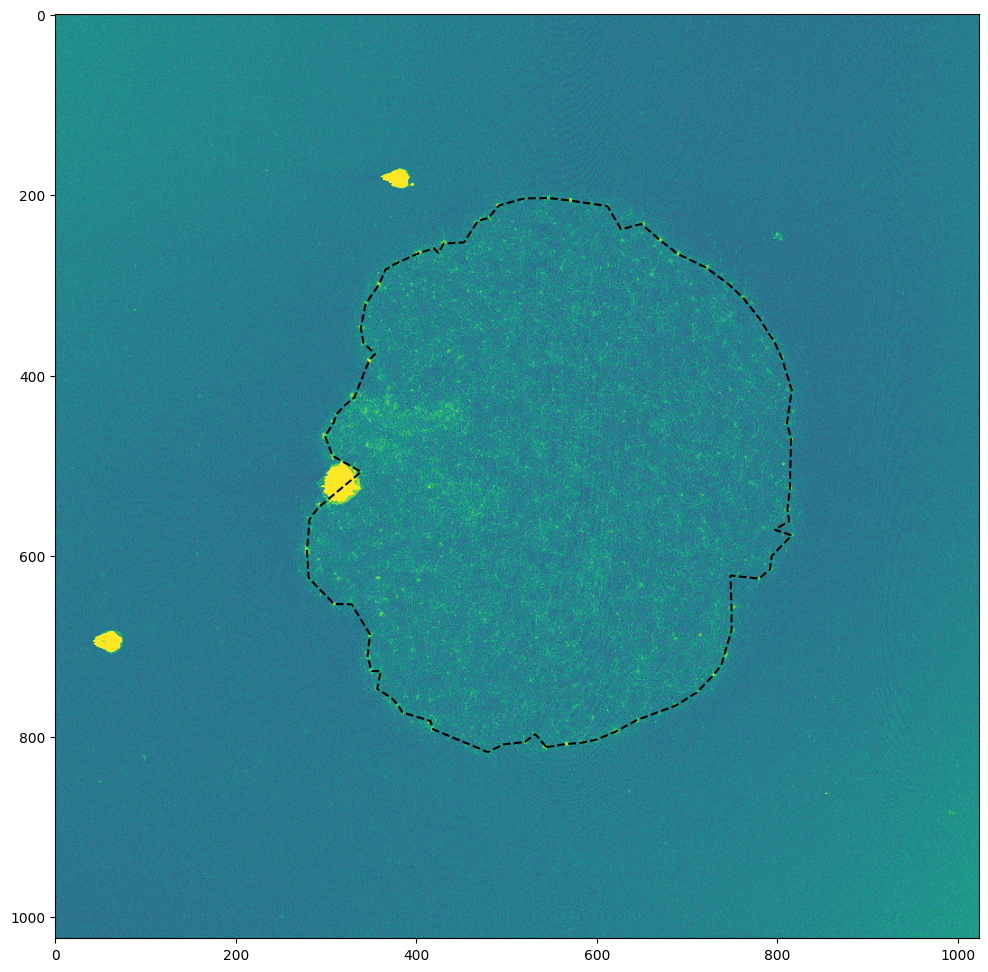

In [268]:
plt.imshow(fibril_rosette_mask.astype(bool))
plt.imshow(edges, alpha=0.6, cmap='gray')
plt.show()

edge_positions = np.transpose(np.nonzero(edges))
region_props = regionprops(fibril_rosette_mask)
min_distances = np.zeros(len(region_props))
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    min_distances[props_index] = min_distance

print(f'mean distance: {np.mean(min_distances)}')
print(f'std dev distance: {np.std(min_distances)}')
plt.hist(min_distances, bins='auto')
plt.show()
distance_threshold = np.mean(min_distances) - Threshold_Dist * np.std(min_distances)
print(f'distance threshold: {distance_threshold}')

removed_too_far_points = fibril_rosette_mask.copy()
points = np.array([])
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    if min_distance > distance_threshold:
        removed_too_far_points[removed_too_far_points == proplabel] = 0
    else:
        points = np.append(points, centroid).reshape(-1, 2)

points = np.array(points)
print(f'points shape: {points.shape}')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(removed_too_far_points.astype(bool))
plt.show()

# Find centroids of remaining points
labelled = label(removed_too_far_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(flattened, vmin=-3, vmax=4)
ax.plot(xs, ys, 'k--')

plt.show()


In [269]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [270]:
def point_distances(points: np.ndarray):
    distance_matrix = distance.cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [271]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [272]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    max_heights = np.zeros(len(region_props))
    mean_heights = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume
        max_heights[props_index] = np.max(region_values)
        mean_heights[props_index] = np.mean(region_values)

    return {
        'areas': areas,
        'volumes': volumes,
        'max_heights': max_heights,
        'mean_heights': mean_heights,
        'number_of_regions': len(region_props),
    }

In [273]:
def curvature(xs: np.ndarray, ys: np.ndarray):
    extension_length = xs.shape[0]
    xs_extended = np.append(xs, xs)
    xs_extended = np.append(xs_extended, xs)
    ys_extended = np.append(ys, ys)
    ys_extended = np.append(ys_extended, ys)
    dx = np.gradient(xs_extended)
    dy = np.gradient(ys_extended)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)
    curv = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5
    #curv = curv[extension_length:(len(curv)-extension_length)+1]
    return curv

In [274]:
def is_clockwise(p_1: tuple, p_2: tuple, p_3: tuple) -> bool:
    """Function to determine if three points make a clockwise or counter-clockwise turn.

    Parameters
    ----------
    p_1: tuple
        First point to be used to calculate turn.
    p_2: tuple
        Second point to be used to calculate turn.
    p_3: tuple
        Third point to be used to calculate turn.

    Returns
    -------
    boolean
        Indicator of whether turn is clockwise.
    """

    rotation_matrix = np.array(((p_1[0], p_1[1], 1), (p_2[0], p_2[1], 1), (p_3[0], p_3[1], 1)))
    return not np.linalg.det(rotation_matrix) > 0

def get_triangle_height(base_point_1: np.array, base_point_2: np.array, top_point: np.array) -> float:
    """Returns the height of a triangle defined by the input point vectors.
    Parameters
    ----------
    base_point_1: np.ndarray
        a base point of the triangle, eg: [5, 3].

    base_point_2: np.ndarray
        a base point of the triangle, eg: [8, 3].

    top_point: np.ndarray
        the top point of the triangle, defining the height from the line between the two base points, eg: [6,10].

    Returns
    -------
    Float
        The height of the triangle - ie the shortest distance between the top point and the line between the two base points.
    """

    # Height of triangle = A/b = ||AB X AC|| / ||AB||
    a_b = base_point_1 - base_point_2
    a_c = base_point_1 - top_point
    return np.linalg.norm(np.cross(a_b, a_c)) / np.linalg.norm(a_b)

def ferets(edges: np.ndarray) -> float:
    """Returns the minimum and maximum feret diameters for a grain.
    These are defined as the smallest and greatest distances between
    a pair of callipers that are rotating around a 2d object, maintaining
    contact at all times.

    Parameters
    ----------
    edge_points: list
        a list of the vector positions of the pixels comprising the edge of the
        grain. Eg: [[0, 0], [1, 0], [2, 1]]
    Returns
    -------
    min_feret: float
        the minimum feret diameter of the grain
    max_feret: float
        the maximum feret diameter of the grain"""

    # Sort the vectors by x coordinate then y coordinate
    sorted_indices = np.lexsort((edges[:, 1], edges[:, 0]))
    sorted = edges[sorted_indices]

    # Construct upper and lower hulls for the edge points.
    upper_hull = []
    lower_hull = []
    for point in sorted:
        #print(point)
        while len(lower_hull) > 1 and is_clockwise(lower_hull[-2], lower_hull[-1], point):
            lower_hull.pop()
        lower_hull.append(point)
        while len(upper_hull) > 1 and not is_clockwise(upper_hull[-2], upper_hull[-1], point):
            upper_hull.pop()
        upper_hull.append(point)
    
    upper_hull = np.array(upper_hull)
    lower_hull = np.array(lower_hull)

    # Create list of contact vertices for calipers on the antipodal hulls
    contact_points = []
    upper_index = 0
    lower_index = len(lower_hull) - 1
    min_feret = None
    while upper_index < len(upper_hull) - 1 or lower_index > 0:
        contact_points.append([lower_hull[lower_index, :], upper_hull[upper_index, :]])
        # If we have reached the end of the upper hull, continute iterating over the lower hull
        if upper_index == len(upper_hull) - 1:
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # If we have reached the end of the lower hull, continue iterating over the upper hull
        elif lower_index == 0:
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # Check if the gradient of the last point and the proposed next point in the upper hull is greater than the gradient
        # of the two corresponding points in the lower hull, if so, this means that the next point in the upper hull
        # will be encountered before the next point in the lower hull and vice versa.
        # Note that the calculation here for gradients is the simple delta upper_y / delta upper_x > delta lower_y / delta lower_x
        # however I have multiplied through the denominators such that there are no instances of division by zero. The
        # inequality still holds and provides what is needed.
        elif (upper_hull[upper_index + 1, 1] - upper_hull[upper_index, 1]) * (
            lower_hull[lower_index, 0] - lower_hull[lower_index - 1, 0]
        ) > (lower_hull[lower_index, 1] - lower_hull[lower_index - 1, 1]) * (
            upper_hull[upper_index + 1, 0] - upper_hull[upper_index, 0]
        ):
            # If the upper hull is encoutnered first, increment the iteration index for the upper hull
            # Also consider the triangle that is made as the two upper hull vertices are colinear with the caliper
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        else:
            # The next point in the lower hull will be encountered first, so increment the lower hull iteration index.
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )

            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret

    contact_points = np.array(contact_points)

    # Find the minimum and maximum distance in the contact points
    max_feret = None
    for point_pair in contact_points:
        dist = np.sqrt((point_pair[0, 0] - point_pair[1, 0]) ** 2 + (point_pair[0, 1] - point_pair[1, 1]) ** 2)
        if max_feret is None or max_feret < dist:
            max_feret = dist

    return min_feret, max_feret

In [275]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = shoelace(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ferets(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = region_stats(labelled_image=labelled, image=flattened)
curv = curvature(xs,ys)
print(f'mean_curvature: {np.mean(curv)}')
print(f'sum_curvature: {np.sum(curv)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["mean_heights"]):.2f} nm max: {np.max(regionstats["mean_heights"]):.2f} nm mean: {np.mean(regionstats["mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["max_heights"]):.2f} nm max: {np.max(regionstats["max_heights"]):.2f} nm mean: {np.mean(regionstats["max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(curv,"\n")
print("---------------------------------------------------------------")

Image: Flat\20230118_KPN001.0_00011.spm
- molecule stats -
area: 39.62 μm^2
perimeter: 25.43 μm
min_feret: 6.68 μm | max_feret: 7.86 μm
mean_curvature: 0.013337420802105827
sum_curvature: 3.4010423045369857
- node stats -
number of nodes in perimeter: 84
node areas | min: 1610.40 nm^2 max: 14493.56 nm^2 mean: 4342.32 nm^2
node volumes | min: 2245.00 nm^3 max: 25399.47 nm^3 mean: 7956.84 nm^3
mean node height values | min: 1.39 nm max: 2.30 nm mean: 1.79 nm
max node height values | min: 1.84 nm max: 5.49 nm mean: 3.07 nm

Full Curvature Values:
[1.24808205e-03 6.51114905e-04 7.20571951e-03 7.89083094e-03
 8.94461561e-04 2.93127955e-05 2.80076676e-03 8.35543653e-03
 9.23562875e-03 2.61010478e-02 7.39520107e-03 5.82990716e-03
 5.97948933e-03 3.53988114e-02 2.32879248e-03 3.85775098e-02
 5.67214990e-03 2.87002191e-02 3.83087277e-02 1.19717654e-02
 8.45456892e-03 8.99358088e-04 8.49383095e-04 9.29798727e-04
 3.90644285e-03 6.61147108e-03 1.40197043e-02 6.13393897e-03
 2.57479788e-03 5.04394